# PRIM to Find Worst Case Scenarios

In this notebook, prim will be used to find the policy levers that should be avoided. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from ema_workbench.analysis import prim
from ema_workbench import ema_logging
from ema_workbench import SequentialEvaluator

from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

The dike_model is fetched with problem formulation 3

In [2]:
# First, get the model
dike_model, planning_steps = get_model_for_problem_formulation(3)
print(dike_model)
print(planning_steps)

# We will need experiments and outcomes, for the sake of scoping they are listed here
experiments, outcomes = (...,...)

[0 1 2]


Running the model takes a long time, so that can be avoided by reading the model from a file.

In [3]:
# Optional: run the model a bunch of times and save it to a file, change boolean below if you want to run it or not
# False means: don't run it and use the presaved data
# True means: do run the program
want_to_run = False

if want_to_run:
    with SequentialEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=100, policies=30)
        
    # split the results into experiments and outcomes
    experiments, outcomes = results
    experiments.info()
    
    #save the results so that this (which takes like 2 hours) doesn't need to be rerun over and over
    with open('data from all the runs', 'wb') as file:
        pickle.dump(results, file)
    

In [4]:
if not want_to_run:
    # open the results so that you do prim on them
    with open('data from all the runs', 'rb') as file:
        loaded_data = pickle.load(file)
    experiments, outcomes = loaded_data
    print(outcomes)

{'A.1 Total Costs': array([1.94659397e+08, 1.94659397e+08, 1.94659397e+08, ...,
       8.52460193e+07, 8.52460193e+07, 8.52460193e+07]), 'A.1_Expected Number of Deaths': array([0., 0., 0., ..., 0., 0., 0.]), 'A.2 Total Costs': array([2.11704040e+08, 2.08510939e+08, 2.08510939e+08, ...,
       2.12039158e+08, 2.19001990e+08, 2.12039158e+08]), 'A.2_Expected Number of Deaths': array([0.00450829, 0.        , 0.        , ..., 0.        , 0.0065977 ,
       0.        ]), 'A.3 Total Costs': array([1.76088342e+08, 1.76088342e+08, 1.76088342e+08, ...,
       1.02228374e+08, 1.02228374e+08, 1.02228374e+08]), 'A.3_Expected Number of Deaths': array([0., 0., 0., ..., 0., 0., 0.]), 'A.4 Total Costs': array([46653655.91965508, 46653655.91965508, 46653655.91965508, ...,
       45041765.16252795, 45041765.16252795, 45651497.37298745]), 'A.4_Expected Number of Deaths': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00040016]), 'A.5 Total Costs': array([1.62406519e+08, 1

The data needs to be cleaned, so unnecesary columns are dropped. The number of the scenario or policy are not relevant and the name of the model stays the same, so that can be removed. Then, the two interesting parts are the costs and the deaths, so those are summed up.

In [5]:
# Datacleaning
experiments.head()

# Remove irrelevant columns
experiments.drop(columns=['policy', 'scenario', 'model'], inplace = True)

In [6]:
df = pd.DataFrame(outcomes)

# Summing the total costs
df['Total Costs'] = df[['A.1 Total Costs', 'A.2 Total Costs', 'A.3 Total Costs', 
                        'A.4 Total Costs', 'A.5 Total Costs', 'RfR Total Costs', 
                        'Expected Evacuation Costs']].sum(axis=1)

# Summing the total expected number of deaths
df['Total Deaths'] = df[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 
                         'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 
                         'A.5_Expected Number of Deaths']].sum(axis=1)


Any policy that is very expensive and does not guarantee 0 deaths should be seen as unacceptable, therefore those are marked.

In [7]:
#250 000 000 budget euro

# Define what policies are deemed unacceptable
df['Unacceptable'] = ( (df['Total Deaths'] > 0.0) & (df['Total Costs'] > 300000000)).astype(int) 
# Turn these values into the y variable in the form of an array
y = df['Unacceptable'].values
print(y)
print(df['Unacceptable'].value_counts(1))

[1 0 0 ... 0 1 1]
1    0.746667
0    0.253333
Name: Unacceptable, dtype: float64


[MainProcess/INFO] 3000 points remaining, containing 2240 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.21, coverage: 0.28125, density: 1.0 restricted_dimensions: 6


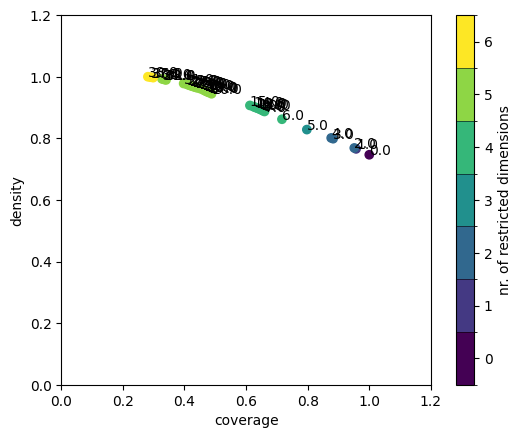

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)

#Perform prim
prim_alg = prim.Prim(experiments, y, threshold=0.7, peel_alpha=0.05)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()



In [9]:
# Pick a point
point = 5
box1.inspect(point)

coverage       0.797321
density        0.828386
id             5.000000
k           1786.000000
mass           0.718667
mean           0.828386
n           2156.000000
res_dim        3.000000
Name: 5, dtype: float64

                                                                box 5  \
                                                                  min   
A.3_DikeIncrease 0                                                0.0   
A.3_DikeIncrease 1                                                1.0   
num_events          {30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 4...   

                                                                       \
                                                                  max   
A.3_DikeIncrease 0                                                9.0   
A.3_DikeIncrease 1                                                9.0   
num_events          {30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 4...   

                                        
          

[None]

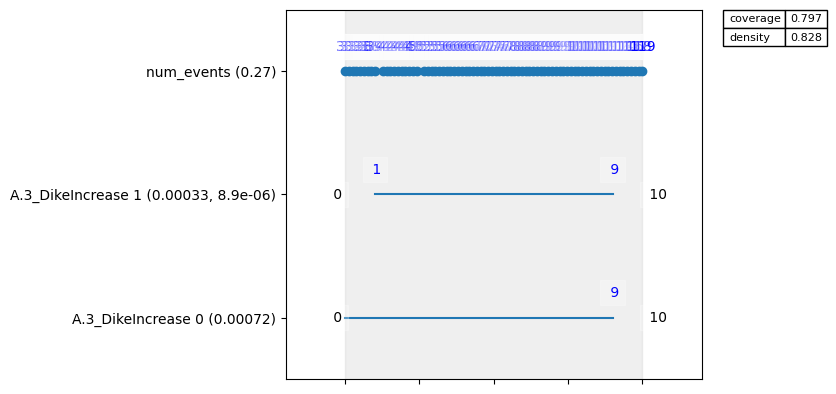

In [10]:
# Make the weird plot thing
box1.inspect(point, style='graph')
plt.show()

In [13]:
# See how reproducable it is
print(np.version.version)
box1.resample(5)

[MainProcess/INFO] resample 1


1.26.4


[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
#Make pretty plots for the chosen point
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()